# Import libraries

In [111]:
import pandas as pd
import seaborn as sns
import numpy as np
import sqlite3
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt 

# Connect to database and look at the attributes of the dataframe

In [3]:
# connect to sql database
db_path = "/Users/shangweisong/Desktop/AIAP_Hotel_pred/data/noshow.db"
conn = sqlite3.connect(db_path)

# Find table name 
tablename_query = "SELECT name FROM sqlite_master WHERE type='table';"
tablename= pd.read_sql_query(tablename_query, conn)

# Get data from database
df_query = f"SELECT * FROM {tablename.iloc[0,0]};"
df= pd.read_sql_query(df_query, conn)

print(df.head(10))

print(df.info())       # Data types and non-null counts
print(df.describe())   # Summary statistics for numerical columns
print(df.columns)      # List of column names
print(df.dtypes)       # Data types of each column
print(df.isnull().sum())  # Count of missing values in each column


   booking_id  no_show   branch booking_month arrival_month  arrival_day  \
0       94113      0.0   Changi      November          June         25.0   
1       86543      0.0  Orchard        August      November         28.0   
2       75928      0.0   Changi         March      February          7.0   
3       66947      1.0  Orchard     September       October          1.0   
4      106390      0.0  Orchard         March          June         20.0   
5       55212      0.0  Orchard      November     September         12.0   
6       42322      0.0  Orchard      November       October         15.0   
7       23137      0.0   Changi          July      November         18.0   
8      109456      1.0   Changi       January          June         27.0   
9       31117      0.0  Orchard       October         March         22.0   

  checkout_month  checkout_day    country first_time    room         price  \
0           June          27.0  Singapore        Yes  Single   SGD$ 492.98   
1      

Getting insights on how to clean data

In [4]:
# Getting insights on how to clean data
for column in df.columns:
    print(f"Unique values in {column}: {df[column].unique()}")

Unique values in booking_id: [94113 86543 75928 ... 81936  6738 99643]
Unique values in no_show: [ 0.  1. nan]
Unique values in branch: ['Changi' 'Orchard' None]
Unique values in booking_month: ['November' 'August' 'March' 'September' 'July' 'January' 'October' 'June'
 'December' 'April' 'May' 'February' None]
Unique values in arrival_month: ['June' 'November' 'February' 'October' 'September' 'March' 'May' 'August'
 'July' 'January' 'April' 'December' 'ApRiL' 'OcTobeR' 'JuNe' 'JulY'
 'ApriL' 'OctOber' 'DecembEr' 'SeptEmber' 'JanUary' 'JUne' 'FeBruary'
 'JanuarY' 'DEcember' 'SePtember' 'DecembeR' 'MaY' 'NoVember' 'JUly'
 'JunE' 'JuLy' 'FebrUary' 'NOvember' 'SeptemBer' 'OctobeR' 'DecemBer'
 'MarCh' 'AuguSt' 'AugusT' 'APril' 'SepTember' 'NovembEr' 'FEbruary'
 'DeceMber' 'AuGust' 'SepteMber' 'FebruaRy' 'OctoBer' 'JanuaRy' 'MarcH'
 'ApRil' 'AUgust' 'JanuAry' 'NOveMber' 'MaRch' 'AprIl' 'MAy' 'NovemBer'
 'DecEmber' 'MArch' 'JaNuary' 'NovembeR' 'SeptembEr' 'FebruarY'
 'SeptembeR' 'OcTober' 'De

# Cleaning data of data 1st attempt

Dropping all null value first to observe the correlation of between the features before deciding on how to handle missing data

In [5]:

df_cleaned = df.drop_duplicates(subset = 'booking_id', keep= 'first')
df_cleaned = df_cleaned.dropna()
df_cleaned = df_cleaned.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
df_cleaned['checkout_day'] = df_cleaned['checkout_day'].abs()
df_cleaned['num_adults'] = df_cleaned['num_adults'].replace({'one': 1, 'two': 2})
df_cleaned= df_cleaned.drop(['booking_id'],axis=1)



# Feature engineering

Transform price column into numerical value in sgd and currency type 

In [6]:
conversion_rates = {
    'usd': 1.37,  # Example: 1 USD = 1.37 SGD
    'sgd': 1.00,  # SGD remains the same
}

df_cleaned['currency']= df_cleaned['price'].str.extract(r'(\w+)\$')
df_cleaned['amount']= df_cleaned['price'].str.extract(r'\$ (\d+(\.\d+)?)')[0].astype(float)
df_cleaned['amount_in_sgd'] = df_cleaned.apply(lambda row: row['amount'] * conversion_rates.get(row['currency'].lower(), 1), axis=1).round(2)
# drop irrelevant price column
df_cleaned= df_cleaned.drop(['amount','price'],axis=1 )


Find duration between booking month to arrival month
Find intended stay duration

In [7]:
# convert month to integer
df_cleaned['booking_month_int'] = pd.to_datetime(df_cleaned['booking_month'],format='%B').dt.month
df_cleaned['arrival_month_int'] = pd.to_datetime(df_cleaned['arrival_month'],format='%B').dt.month
df_cleaned['checkout_month_int']= pd.to_datetime(df_cleaned['checkout_month'],format='%B').dt.month
# find booking duration
df_cleaned['book_duration']= (df_cleaned['arrival_month_int']- df_cleaned['booking_month_int']).abs()

default_year=2024
df_cleaned['arrival_date'] = pd.to_datetime({
    'year': default_year,
    'month': df_cleaned['arrival_month_int'],
    'day': df_cleaned['arrival_day']
})

df_cleaned['checkout_date'] = pd.to_datetime({
    'year': default_year,
    'month': df_cleaned['checkout_month_int'],
    'day': df_cleaned['checkout_day']
})

# add 1 year if checkout date earlier than arrival date
df_cleaned['checkout_date'] = df_cleaned.apply(
    lambda row: row['checkout_date'] if row['checkout_date'] >= row['arrival_date']
    else row['checkout_date'] + pd.DateOffset(years=1),
    axis=1
)
# find stay_duration in days
df_cleaned['stay_duration'] = (df_cleaned['checkout_date']-df_cleaned['arrival_date']).dt.days

# remove irrelevant columns
df_cleaned= df_cleaned.drop(['arrival_month', 'booking_month', 'checkout_month_int','checkout_date','arrival_date'], axis=1)

In [8]:
# Getting insights on how to clean data
for column in df_cleaned.columns:
    print(f"Unique values in {column}: {df_cleaned[column].unique()}")

Unique values in no_show: [0. 1.]
Unique values in branch: ['changi' 'orchard']
Unique values in arrival_day: [25. 28.  1. 20. 15.  9. 11. 10. 13. 21.  5.  6. 27. 31.  3.  4.  2.  7.
 22. 23. 17. 14. 24. 29. 26. 19. 16.  8. 12. 18. 30.]
Unique values in checkout_month: ['june' 'november' 'october' 'march' 'may' 'august' 'july' 'january'
 'april' 'september' 'february' 'december']
Unique values in checkout_day: [27. 29.  3. 24. 16. 10. 12. 13. 11. 25. 17. 23.  8.  2.  9.  1.  4. 28.
  6. 21.  5. 15.  7. 18. 19. 22. 14. 20. 30. 26. 31.]
Unique values in country: ['singapore' 'indonesia' 'china' 'australia' 'japan' 'india' 'malaysia']
Unique values in first_time: ['yes' 'no']
Unique values in room: ['single' 'king' 'queen' 'president suite']
Unique values in platform: ['website' 'email' 'agent' 'phone']
Unique values in num_adults: ['1' '2' 1 2]
Unique values in num_children: [0. 1. 2. 3.]
Unique values in currency: ['sgd' 'usd']
Unique values in amount_in_sgd: [ 492.98 1351.22  666.04 ..

Standardise numerical data and one-hot encode categorical

My intepretation of datatype
| Feature Name        | Data Type      |
|---------------------|----------------|
| no_show             | Categorical    |
| branch              | Categorical    |
| arrival_day         | Categorical    |
| checkout_month      | Categorical    |
| checkout_day        | Categorical    |
| country             | Categorical    |
| first_time          | Categorical    |
| room                | Categorical    |
| platform            | Categorical    |
| currency            | Categorical    |
| booking_month       | Cyclical       |
| arrival_month       | Cyclical       |
| num_adults          | Numerical      |
| num_children        | Numerical      |
| amount_in_sgd       | Numerical      |
| book_duration       | Numerical      |
| stay_duration       | Numerical      |





In [9]:
# define datatype

numerical_columns= ['num_adults', 'num_children','amount_in_sgd','book_duration','stay_duration','no_show']
categorical_columns= ['branch','arrival_day','checkout_month','checkout_day','country','first_time','room','platform','currency']
cyclical_columns=['booking_month_int', 'arrival_month_int']

df_encoded = pd.get_dummies(df_cleaned, columns=categorical_columns, drop_first=True)
# convert bool to 0,1
bool_columns = df_encoded.select_dtypes(include=['bool']).columns
df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)

# Standardize the numerical columns
scaler = StandardScaler()
df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])


# encode cyclical data

df_encoded['sin_booking_month'] = np.sin(2 * np.pi * df_cleaned['booking_month_int'] / 12)
df_encoded['cos_booking_month'] = np.cos(2 * np.pi * df_cleaned['booking_month_int'] / 12)

df_encoded['sin_arrival_month'] = np.sin(2 * np.pi * df_cleaned['arrival_month_int'] / 12)
df_encoded['cos_arrival_month'] = np.cos(2 * np.pi * df_cleaned['arrival_month_int'] / 12)

# Display the processed DataFrame
print(df_encoded.head(10))

     no_show  num_adults  num_children  amount_in_sgd  booking_month_int  \
0  -0.767577   -0.855915     -1.118248      -1.717258                 11   
1  -0.767577    1.168341     -1.118248       1.515173                  8   
3   1.302801   -0.855915     -1.118248      -1.065454                  9   
4  -0.767577   -0.855915     -1.118248      -0.140740                  3   
6  -0.767577   -0.855915      0.163848       1.606394                 11   
10 -0.767577    1.168341      1.445944       1.992708                 10   
11  1.302801   -0.855915      1.445944      -0.304840                  3   
12 -0.767577    1.168341     -1.118248      -0.298324                  3   
13  1.302801   -0.855915     -1.118248      -0.544982                  6   
14 -0.767577    1.168341      1.445944       1.482405                  7   

    arrival_month_int  book_duration  stay_duration  branch_orchard  \
0                   6       0.511455      -0.053590               0   
1                  11

In [10]:
df_corr= df_encoded
corr_matrix_fill=  df_corr.corr()
price_corr = corr_matrix_fill['amount_in_sgd'].abs().sort_values(ascending=False)


print(price_corr[price_corr >= 0.1])


amount_in_sgd           1.000000
branch_orchard          0.642388
room_single             0.581266
room_president suite    0.324601
num_adults              0.218105
num_children            0.160369
country_china           0.142454
Name: amount_in_sgd, dtype: float64


In [11]:
df_corr= df_encoded
corr_matrix_fill=  df_corr.corr()
price_corr = corr_matrix_fill['room_president suite'].abs().sort_values(ascending=False)


print(price_corr[price_corr >= 0.1])


room_president suite    1.000000
amount_in_sgd           0.324601
branch_orchard          0.119904
Name: room_president suite, dtype: float64


# Preparing dataset for ML

Fill missing price according by taking the average of price of same type of room and same branch  
Fill missing room type by analysing price and branch

In [94]:
df_ml = df.drop_duplicates(subset = 'booking_id', keep= 'first')
df_ml= df_ml.drop(['booking_id'],axis=1)
df_ml= df_ml.dropna(how= 'all')
df_ml = df_ml.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
df_ml['checkout_day'] = df_ml['checkout_day'].abs()
df_ml['num_adults'] = df_ml['num_adults'].replace({'one': 1, 'two': 2, '1': 1, '2': 2})



/var/folders/0d/12spm1y90s559_tdr7d3w0500000gn/T/ipykernel_90770/1265364139.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ml['num_adults'] = df_ml['num_adults'].replace({'one': 1, 'two': 2, '1': 1, '2': 2})


In [95]:
conversion_rates = {
    'usd': 1.37,  # Example: 1 USD = 1.37 SGD
    'sgd': 1.00,  # SGD remains the same
}

# Extract currency and amount , default to NaN for missing values 
df_ml['currency'] = df_ml['price'].str.extract(r'(\w+)\$', expand=False)
df_ml['amount'] = pd.to_numeric(
    df_ml['price'].str.extract(r'\$ (\d+(\.\d+)?)', expand=False)[0],
    errors='coerce'
)

# Calculate amount in SGD, skipping rows with missing data
df_ml['amount_in_sgd'] = (df_ml.apply(lambda row: row['amount'] * conversion_rates.get(row['currency'].lower(), 1)
        if pd.notnull(row['amount']) and pd.notnull(row['currency'])
        else None,  # Leave as NaN if 'amount' or 'currency' is missing
        axis=1
    )
).round(2)
# drop original price
df_ml = df_ml.drop(['price','amount','currency'], axis=1)

In [97]:

# Group by 'room' and 'branch' and calculate the mean price for each group
average_price = df_ml.groupby(['room', 'branch'])['amount_in_sgd'].mean().reset_index()
average_price = average_price.rename(columns={'amount_in_sgd': 'price_mean'})

# store average price df for later use
room_branch_mean= average_price

# Merge the average price back to the original DataFrame on 'room' and 'branch'
df_ml = df_ml.merge(average_price, on=['room', 'branch'], how='left')

# Fill the null values in 'price' with the calculated 'price_mean'
df_ml['amount_in_sgd'] = df_ml['amount_in_sgd'].fillna(df_ml['price_mean'])

# Drop the irrelevant column
df_ml.drop(columns=['price_mean'], inplace=True)


Fill missing room

In [98]:
# Create a lookup dictionary from the mean price dataframe stored earlier
lookup_dict = room_branch_mean.set_index(['branch', 'room'])['price_mean'].to_dict()

# Function to find the closest room type based on branch and price
def infer_room_type(row):
    if pd.notnull(row['room']):
        return row['room']  # Keep existing room_type if it's not null
    
    # Find the branch and price from the row
    branch = row['branch']
    price = row['amount_in_sgd']
    
    # Filter lookup_dict for the current branch
    branch_rooms = {room: price_mean for (b, room), price_mean in lookup_dict.items() if b == branch}
    
    if not branch_rooms:
        return None  # Return None if no matches for the branch
    
    # Find the room type with the closest price
    closest_room = min(branch_rooms, key=lambda room: abs(branch_rooms[room] - price))
    return closest_room

# Apply the inference function to the DataFrame
df_ml['room'] = df_ml.apply(infer_room_type, axis=1)

Rest of the feature engineering

In [99]:
# convert month to integer
df_ml['booking_month_int'] = pd.to_datetime(df_ml['booking_month'],format='%B').dt.month
df_ml['arrival_month_int'] = pd.to_datetime(df_ml['arrival_month'],format='%B').dt.month
df_ml['checkout_month_int']= pd.to_datetime(df_ml['checkout_month'],format='%B').dt.month
# find booking duration
df_ml['book_duration']= (df_ml['arrival_month_int']- df_ml['booking_month_int']).abs()

default_year=2024
df_ml['arrival_date'] = pd.to_datetime({
    'year': default_year,
    'month': df_ml['arrival_month_int'],
    'day': df_ml['arrival_day']
})

df_ml['checkout_date'] = pd.to_datetime({
    'year': default_year,
    'month': df_ml['checkout_month_int'],
    'day': df_ml['checkout_day']
})

# add 1 year if checkout date earlier than arrival date
df_ml['checkout_date'] = df_ml.apply(
    lambda row: row['checkout_date'] if row['checkout_date'] >= row['arrival_date']
    else row['checkout_date'] + pd.DateOffset(years=1),
    axis=1
)
# find stay_duration in days
df_ml['stay_duration'] = (df_ml['checkout_date']-df_ml['arrival_date']).dt.days

# remove irrelevant columns
df_ml= df_ml.drop(['arrival_month', 'booking_month', 'checkout_month_int','checkout_date','arrival_date'], axis=1)

In [ ]:
df_ml

Encode data 

In [100]:
numerical_columns= ['num_adults', 'num_children','amount_in_sgd','book_duration','stay_duration','no_show']
categorical_columns= ['branch','arrival_day','checkout_month','checkout_day','country','first_time','room','platform',]
cyclical_columns=['booking_month_int', 'arrival_month_int']

df_ml = pd.get_dummies(df_ml, columns=categorical_columns, drop_first=True)
# convert bool to 0,1
bool_columns = df_ml.select_dtypes(include=['bool']).columns
df_ml[bool_columns] = df_ml[bool_columns].astype(int)

# Standardize the numerical columns
scaler = StandardScaler()
df_ml[numerical_columns] = scaler.fit_transform(df_ml[numerical_columns])


# encode cyclical data

df_ml['sin_booking_month'] = np.sin(2 * np.pi * df_ml['booking_month_int'] / 12)
df_ml['cos_booking_month'] = np.cos(2 * np.pi * df_ml['booking_month_int'] / 12)

df_ml['sin_arrival_month'] = np.sin(2 * np.pi * df_ml['arrival_month_int'] / 12)
df_ml['cos_arrival_month'] = np.cos(2 * np.pi * df_ml['arrival_month_int'] / 12)


In [85]:
corr_matrix = df_encoded.corr()
no_show_corr = corr_matrix['no_show']

sorted_corr = no_show_corr.abs().sort_values(ascending=False)
# sns.heatmap(sorted_corr.values.reshape(1, -1), annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation'}, vmin=-1, vmax=1)

print(sorted_corr[sorted_corr >= 0.05])


no_show              1.000000
country_china        0.341950
branch_orchard       0.137955
country_india        0.123827
country_japan        0.122210
country_indonesia    0.114661
first_time_yes       0.083635
amount_in_sgd        0.060485
country_singapore    0.051500
room_single          0.050891
Name: no_show, dtype: float64


# Split data for ML

In [102]:

X= df_ml.drop(['no_show'],axis=1)
y= df_ml['no_show']
# X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

pca = PCA(n_components=0.95)  # Keeps 95% of the variance
X_pca = pca.fit_transform(X)
X_train, X_test, y_train, y_test= train_test_split(X_pca, y, test_size=0.2, random_state=42)

y_train= y_train.astype(int)
y_test= y_test.astype(int)
# X_pca_df= pd.DataFrame(X_pca)
# print(X_pca_df.head())



In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create the Random Forest Classifier instance
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model to the training data
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.91      0.84     15111
           1       0.79      0.56      0.65      8767

    accuracy                           0.78     23878
   macro avg       0.78      0.74      0.75     23878
weighted avg       0.78      0.78      0.77     23878



In [90]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint
# Baseline model
print("Training baseline Random Forest...")
rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(X_train, y_train)
baseline_preds = rf_baseline.predict(X_test)
print("Baseline Accuracy:", accuracy_score(y_test, baseline_preds))

# Define hyperparameter distribution for Randomized Search
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(10, 50, 10)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2']
}

# Randomized Search
print("\nStarting RandomizedSearchCV...")
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    cv=0,       # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit Randomized Search
random_search.fit(X_train, y_train)
print("\nBest Parameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)

# Train final model with best parameters
print("\nTraining final model...")
rf_final = RandomForestClassifier(**random_search.best_params_, random_state=42)
rf_final.fit(X_train, y_train)

# Evaluate on test set
final_preds = rf_final.predict(X_test)
print("\nFinal Test Accuracy:", accuracy_score(y_test, final_preds))
print("\nClassification Report:\n", classification_report(y_test, final_preds))

# Feature importance
feature_importances = rf_final.feature_importances_
print("\nFeature Importances:")
for name, importance in zip(X.columns, feature_importances):
    print(f"{name}: {importance:.4f}")

Training baseline Random Forest...


KeyboardInterrupt: 

Logistic Regression

In [103]:
from sklearn.linear_model import LogisticRegression
lr_baseline = LogisticRegression(random_state=42, max_iter=1000)
lr_baseline.fit(X_train, y_train)
baseline_preds = lr_baseline.predict(X_test)
print("\nBaseline Accuracy:", accuracy_score(y_test, baseline_preds))
print("\nClassification Report:\n", classification_report(y_test, baseline_preds))


Baseline Accuracy: 0.711031074629366

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.84      0.79     15111
           1       0.64      0.48      0.55      8767

    accuracy                           0.71     23878
   macro avg       0.69      0.66      0.67     23878
weighted avg       0.70      0.71      0.70     23878



In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a baseline logistic regression model
print("Training baseline Logistic Regression...")
lr_baseline = LogisticRegression(random_state=42, max_iter=1000)
lr_baseline.fit(X_train, y_train)

# Evaluate the baseline model
baseline_preds = lr_baseline.predict(X_test)
print("\nBaseline Accuracy:", accuracy_score(y_test, baseline_preds))
print("\nClassification Report:\n", classification_report(y_test, baseline_preds))

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization type
    'solver': ['lbfgs', 'saga'],  # Solver (saga supports all penalties)
}
print("\nStarting hyperparameter tuning with GridSearchCV...")
lr = LogisticRegression(random_state=42, max_iter=1000)
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

# Best parameters and cross-validation score
print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Train the final model with the best parameters
print("\nTraining final Logistic Regression model...")
lr_final = LogisticRegression(**grid_search.best_params_, random_state=42, max_iter=1000)
lr_final.fit(X_train, y_train)

# Evaluate the final model
final_preds = lr_final.predict(X_test)
print("\nFinal Test Accuracy:", accuracy_score(y_test, final_preds))
print("\nFinal Classification Report:\n", classification_report(y_test, final_preds))

# Display confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, final_preds))

KNN

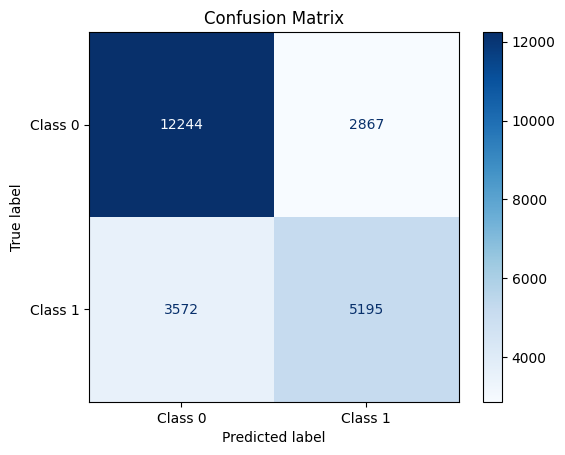

KNN Accuracy: 0.7303375492084764
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79     15111
           1       0.64      0.59      0.62      8767

    accuracy                           0.73     23878
   macro avg       0.71      0.70      0.70     23878
weighted avg       0.73      0.73      0.73     23878

[[12244  2867]
 [ 3572  5195]]


In [113]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)  # Default k=5
knn.fit(X_train, y_train)

# Predict and evaluate
knn_preds = knn.predict(X_test)

cm = confusion_matrix(y_test, knn_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues')  # You can change the color map here
plt.title('Confusion Matrix')
plt.show()
print("KNN Accuracy:", accuracy_score(y_test, knn_preds))
print("Classification Report:\n", classification_report(y_test, knn_preds))
print(cm)


XGBoost

In [108]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
xgb_clf.fit(X_train, y_train)

# Predict and evaluate
xgb_preds = xgb_clf.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print("Classification Report:\n", classification_report(y_test, xgb_preds))
print(confusion_matrix(y_test, xgb_preds))

XGBoost Accuracy: 0.7465030572074713
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.81     15111
           1       0.71      0.52      0.60      8767

    accuracy                           0.75     23878
   macro avg       0.74      0.70      0.71     23878
weighted avg       0.74      0.75      0.74     23878

[[13303  1808]
 [ 4245  4522]]


Neural Networks

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score

# # Load your dataset
# # X = ...  # Features
# # y = ...  # Target

# # Split dataset
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Convert data to PyTorch tensors
# X_train = torch.tensor(X_train, dtype=torch.float32)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_train = torch.tensor(y_train.values, dtype=torch.long)  # Use long for classification
# y_test = torch.tensor(y_test.values, dtype=torch.long)

# # Define Feedforward Neural Network
# class FeedforwardNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(FeedforwardNN, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, output_size)
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.softmax(x)
#         return x

# # Model initialization
# input_size = X_train.shape[1]
# hidden_size = 64
# output_size = len(torch.unique(y_train))
# model = FeedforwardNN(input_size, hidden_size, output_size)

# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Train the model
# epochs = 50
# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()
#     outputs = model(X_train)
#     loss = criterion(outputs, y_train)
#     loss.backward()
#     optimizer.step()

#     if (epoch + 1) % 10 == 0:
#         print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# # Evaluate the model
# model.eval()
# with torch.no_grad():
#     predictions = model(X_test).argmax(dim=1)
#     print("FNN Accuracy:", accuracy_score(y_test, predictions))


# additional stuff 

FIll price with branch and room type information. 

no_show              1.000000
country_china        0.341950
branch_orchard       0.137955
country_india        0.123827
country_japan        0.122210
country_indonesia    0.114661
first_time_yes       0.083635
amount_in_sgd        0.060485
country_singapore    0.051500
room_single          0.050891
Name: no_show, dtype: float64


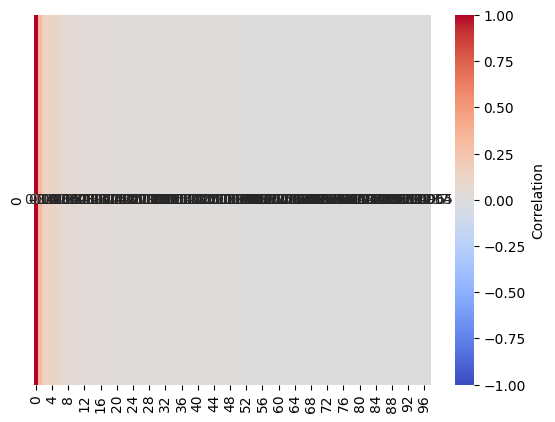

In [ ]:
corr_matrix = df_encoded.corr()
no_show_corr = corr_matrix['no_show']

sorted_corr = no_show_corr.abs().sort_values(ascending=False)
sns.heatmap(sorted_corr.values.reshape(1, -1), annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation'}, vmin=-1, vmax=1)

print(sorted_corr[sorted_corr >= 0.05])

# columns_to_drop = sorted_corr[sorted_corr < 0.05].index
# df_encoded = df_encoded.drop(columns = columns_to_drop, axis =1 )

In [152]:
X=df_encoded.drop(['no_show'],axis=1)
y=df_encoded['no_show'].astype('category')

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
pca = PCA(n_components=0.95)  # Keeps 95% of the variance
X_pca = pca.fit_transform(X)
X_train, X_test, y_train, y_test= train_test_split(X_pca, y, test_size=0.2, random_state=42)

y_train= y_train.astype(int)
y_test= y_test.astype(int)
X_pca_df= pd.DataFrame(X_pca)
print(X_pca_df.head())



          0         1         2         3         4         5
0 -1.892447 -0.130959  0.495735 -0.102355  0.226680  0.881692
1  1.590582 -0.894088  0.056666  0.471924 -0.099987 -0.064052
2 -0.889304  0.539248  1.235185  0.264627 -0.045741 -0.068800
3  0.078257 -0.273950  0.416750 -0.126940  0.163477  0.244526
4  1.699495 -0.396579  0.202975 -0.204813  0.185749  0.218632


In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create the Random Forest Classifier instance
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model to the training data
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.62
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      9205
           1       0.49      0.49      0.49      5375

    accuracy                           0.62     14580
   macro avg       0.59      0.59      0.59     14580
weighted avg       0.62      0.62      0.62     14580



In [ ]:
df_cleaned

In [ ]:
df_cleaned

In [ ]:
# drop irrelevant columns
df_cleaned

In [158]:
for column in df_cleaned.columns:
    print(f'Unique value in {column}:{df_cleaned[column].unique()}')

Unique value in no_show:[0. 1.]
Unique value in branch:['changi' 'orchard']
Unique value in arrival_day:[25. 28.  1. 20. 15.  9. 11. 10. 13. 21.  5.  6. 27. 31.  3.  4.  2.  7.
 22. 23. 17. 14. 24. 29. 26. 19. 16.  8. 12. 18. 30.]
Unique value in checkout_month:['june' 'november' 'october' 'march' 'may' 'august' 'july' 'january'
 'april' 'september' 'february' 'december']
Unique value in checkout_day:[27. 29.  3. 24. 16. 10. 12. 13. 11. 25. 17. 23.  8.  2.  9.  1.  4. 28.
  6. 21.  5. 15.  7. 18. 19. 22. 14. 20. 30. 26. 31.]
Unique value in country:['singapore' 'indonesia' 'china' 'australia' 'japan' 'india' 'malaysia']
Unique value in first_time:['yes' 'no']
Unique value in room:['single' 'king' 'queen' 'president suite']
Unique value in platform:['website' 'email' 'agent' 'phone']
Unique value in num_adults:['1' '2' 1 2]
Unique value in num_children:[0. 1. 2. 3.]
Unique value in currency:['sgd' 'usd']
Unique value in amount_in_sgd:[ 492.98 1351.22  666.04 ... 1127.65  454.74 1426.57]

Check if dropping of null values reuslt in reduced categories

In [159]:
distinct_counts = df.nunique()
distinct_countsdrop= df_cleaned.nunique()
print(distinct_counts)
print(f"\n {distinct_countsdrop}")

booking_id        119391
no_show                2
branch                 2
booking_month         12
arrival_month         88
arrival_day           31
checkout_month        12
checkout_day          62
country                7
first_time             2
room                   4
price              61867
platform               4
num_adults             4
num_children           4
dtype: int64

 no_show                  2
branch                   2
arrival_day             31
checkout_month          12
checkout_day            31
country                  7
first_time               2
room                     4
platform                 4
num_adults               4
num_children             4
currency                 2
amount_in_sgd        42329
booking_month_int       12
arrival_month_int       12
book_duration           12
stay_duration           25
dtype: int64


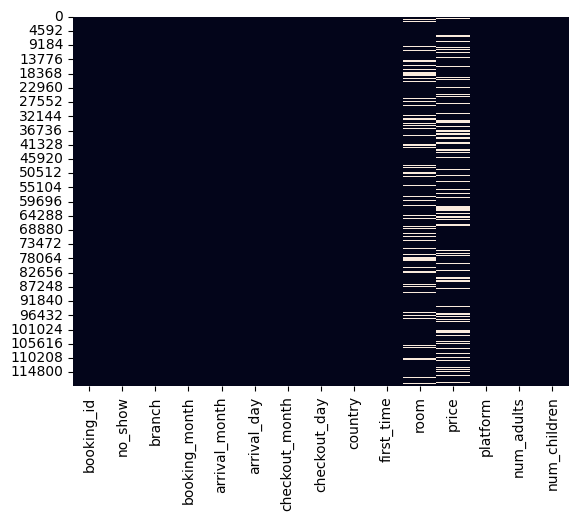

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df.isnull(), cbar=False)
plt.show()

<Axes: >

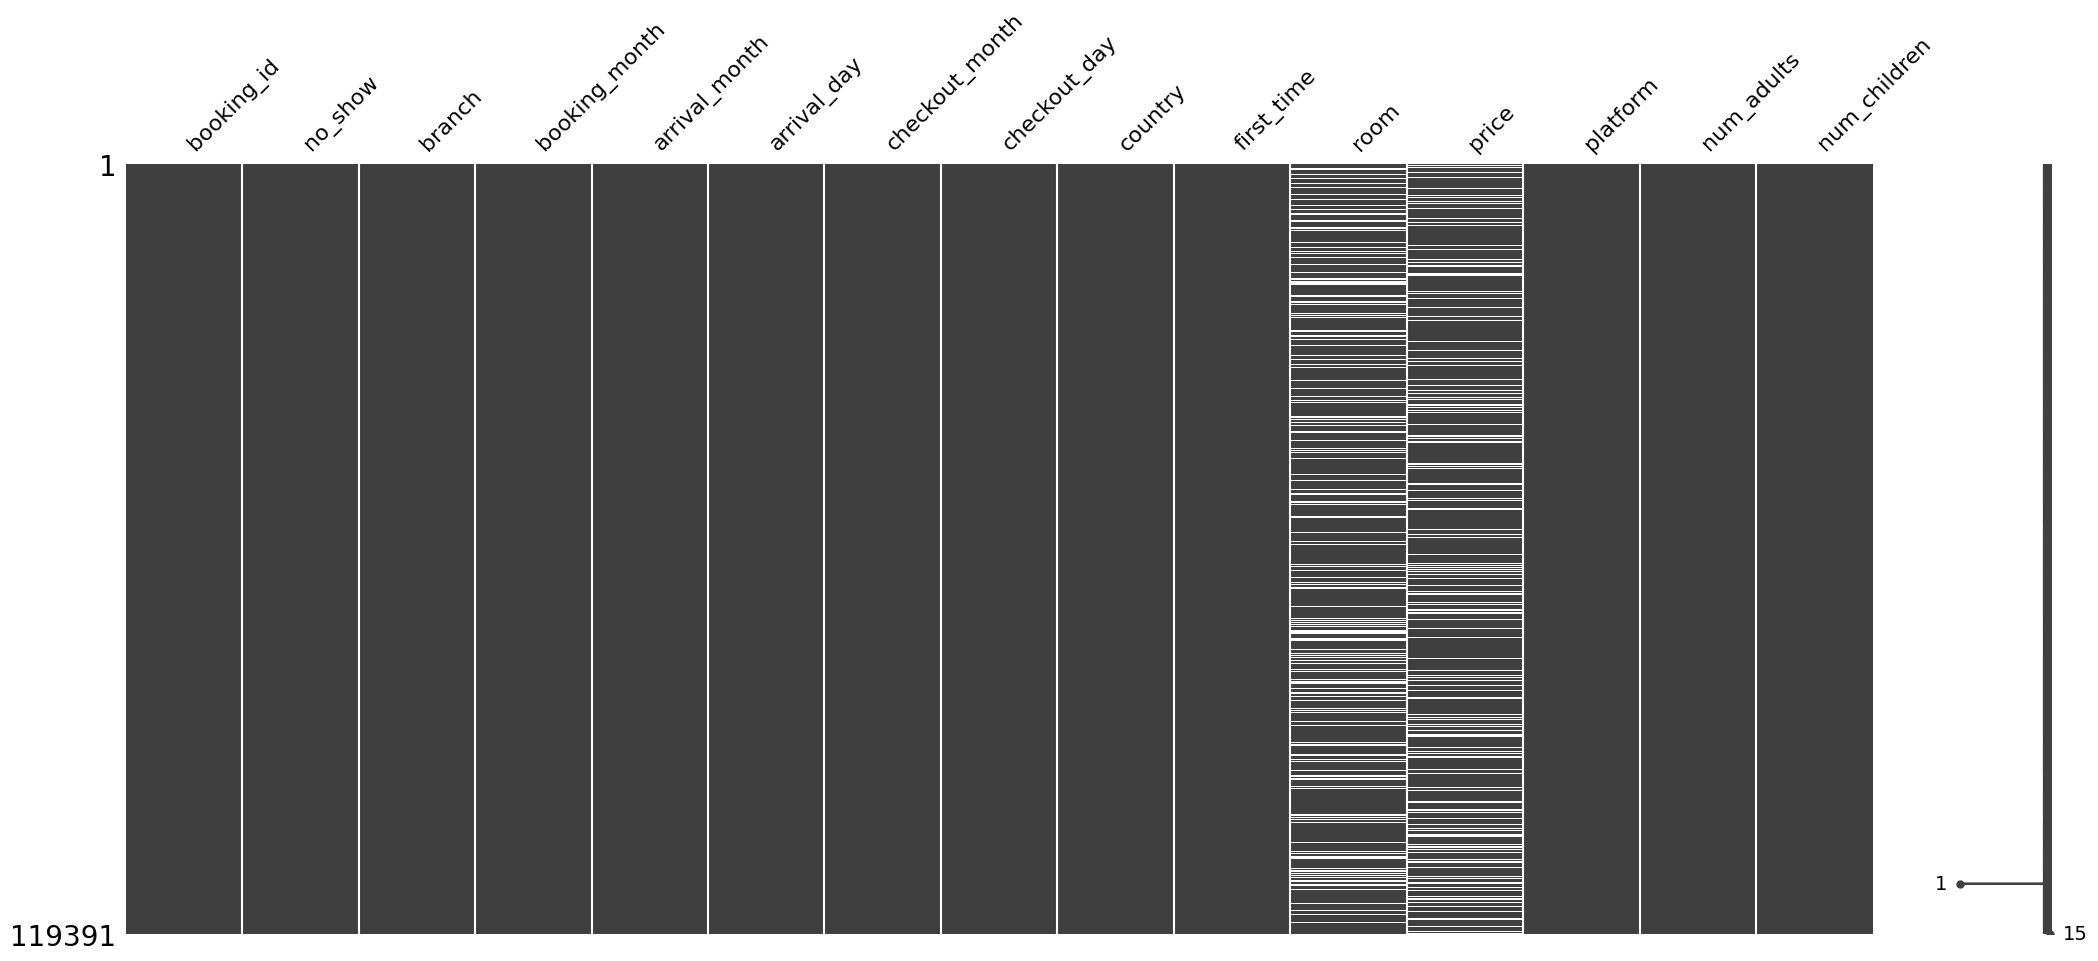

In [5]:
import missingno as msno
msno.matrix(df)

<Axes: >

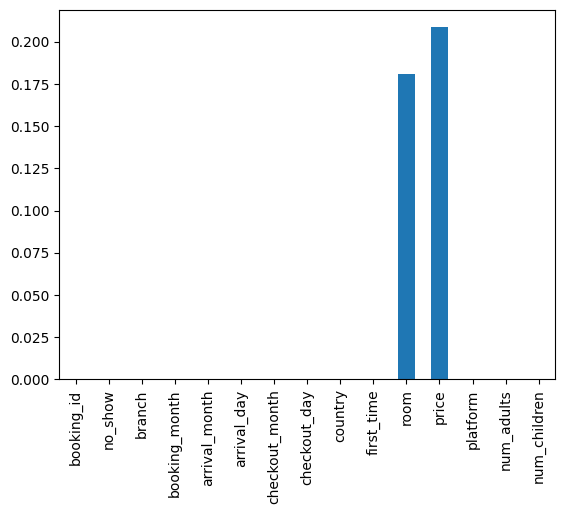

In [6]:
df.isnull().mean().plot(kind='bar')

In [19]:
# from scipy.stats import chi2_contingency
# df_price= df[['price']]
# df_price = df_price['price'].isnull().astype(int)
# df_distinct = df.drop(['price','room','booking_id'], axis=1)
# df_distinct = df_distinct.astype('category') 
# df_room= df[['room']]
# df_room = df_room['room'].isnull().astype(int)
# # print(df_room.head(50))


# for column in df_distinct.columns:
#     # Create a contingency table
#     contingency_table = pd.crosstab(df_room, df_distinct[column])
    
#     # Perform the chi-square test
#     chi2, p, dof, expected = chi2_contingency(contingency_table)
#     print(f"Chi-square test for 'room' and '{column}':")
#     print(f"Chi2: {chi2}, p-value: {p}\n")

#     if p < 0.05:
#         print(f"Significant relationship between 'price_category' and '{column}'\n")
#     else:
#         print(f"No significant relationship between 'price_category' and '{column}'\n")
# # print(f"p-value: {p}")


import scipy.stats as stats
contingency_table = pd.crosstab(df['room'].isnull(), df['branch'])
chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
print(p_value)

# df_price.head(10)

0.8133574356378841


In [24]:
from scipy.stats import chi2_contingency
df_missing= df[['price','room'] ]
df_missing = df_missing[['price','room']].isnull().astype(int)
# print(df_missing.head(20))
df_distinct = df.drop(['price','room','booking_id'], axis=1)
df_distinct = df_distinct.astype('category') 

for j in df_missing.columns:
    for column in df_distinct.columns:
        # Create a contingency table
        contingency_table = pd.crosstab(df_missing[j], df_distinct[column])
        
        # Perform the chi-square test
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        # print(f"Chi2: {chi2}, p-value: {p}\n")
        # print(f"Significant relationship between '{j}' and '{column}'\n")

        if p < 0.05:
            print(f"Chi-square test for '{j}' and '{column}':")
            print(f"Chi2: {chi2}, p-value: {p}\n")
            print(f"Significant relationship between '{j}' and '{column}'\n")
        # else:
        #     print(f"No significant relationship between '{j}' and '{column}'\n")


Chi-square test for 'price' and 'branch':
Chi2: 5.973101909748914, p-value: 0.014525707336282202

Significant relationship between 'price' and 'branch'

Chi-square test for 'price' and 'arrival_day':
Chi2: 47.026419889168274, p-value: 0.024736317976835242

Significant relationship between 'price' and 'arrival_day'

Chi-square test for 'room' and 'arrival_month':
Chi2: 110.72503735391246, p-value: 0.043955451995986154

Significant relationship between 'room' and 'arrival_month'

Chi-square test for 'room' and 'country':
Chi2: 17.845758714015545, p-value: 0.0066294366670059625

Significant relationship between 'room' and 'country'



In [166]:
df = df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

In [167]:
# Filter rows where the 'price' column is null
missing_price = df[df['price'].isnull()]

# Count the number of null 'price' entries for each 'arrival_day'
missing_price_count = missing_price['arrival_day'].value_counts()

# Display the result
print("Number of missing 'price' values for each 'arrival_day':")
print(missing_price_count)

Number of missing 'price' values for each 'arrival_day':
arrival_day
17.0    955
26.0    953
5.0     885
9.0     872
19.0    863
25.0    863
30.0    858
15.0    854
18.0    849
27.0    841
16.0    837
20.0    831
8.0     828
12.0    824
2.0     822
7.0     802
24.0    798
14.0    791
13.0    791
29.0    782
21.0    779
28.0    777
6.0     775
3.0     772
23.0    754
11.0    754
1.0     747
10.0    740
4.0     735
22.0    706
31.0    443
Name: count, dtype: int64


In [168]:
# Filter rows where the 'price' column is null
missing_price = df[df['price'].isnull()]

# Count the number of null 'price' entries for each 'arrival_day'
missing_price_count = missing_price['branch'].value_counts()

# Display the result
print("Number of missing 'price' values for each 'branch':")
print(missing_price_count)

Number of missing 'price' values for each 'branch':
branch
changi     16370
orchard     8511
Name: count, dtype: int64


In [169]:
# Filter rows where the 'price' column is null
missing_room = df[df['room'].isnull()]

# Count the number of null 'price' entries for each 'arrival_day'
missing_room_count = missing_room['arrival_month'].value_counts()

# Display the result
print("Number of missing 'room' values for each 'arrival_month':")
print(missing_room_count)

Number of missing 'room' values for each 'arrival_month':
arrival_month
august       2502
july         2314
may          2125
october      2050
april        2011
june         1965
march        1850
september    1804
february     1523
november     1218
december     1202
january      1048
Name: count, dtype: int64


In [170]:
# Filter rows where the 'price' column is null
missing_room = df[df['room'].isnull()]

# Count the number of null 'price' entries for each 'arrival_day'
missing_room_count = missing_room['country'].value_counts()

# Display the result
print("Number of missing 'room' values for each 'country':")
print(missing_room_count)

Number of missing 'room' values for each 'country':
country
china        8647
indonesia    4660
india        2947
australia    2153
japan        1741
singapore     781
malaysia      683
Name: count, dtype: int64


missing room> look at price ... 
missing price > looking at room price ... 

In [ ]:
rows_all_null = df[df_distinct.isnull().any(axis=1)]

print(rows_all_null)

        booking_id  no_show branch booking_month arrival_month  arrival_day  \
111598      115536      NaN   None          None          None          NaN   

       checkout_month  checkout_day country first_time  room price platform  \
111598           None           NaN    None       None  None  None     None   

       num_adults  num_children  
111598       None           NaN  
